# CIFAR10 与 VGG13 实战

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['font.size'] = 20
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['figure.figsize'] = [12, 10]
plt.rcParams['font.family'] = ['Noto Sans CJK JP'] # ['SimHei']
plt.rcParams['axes.unicode_minus']=False 

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
try:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except RuntimeError as e:
    print(e)

In [3]:
from tensorflow.keras import datasets, losses, metrics, Sequential, layers, optimizers

In [4]:
(X_train, y_train), (X_test, y_test) = datasets.cifar10.load_data()

In [5]:
y_train = np.squeeze(y_train)
y_test = np.squeeze(y_test)

In [6]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3) (50000,) (10000,)


In [7]:
def preprocessing(X, y):
    X = tf.cast(X, dtype=tf.float32) / 255
    y = tf.cast(y, dtype=tf.int32)
    return X, y

In [8]:
train_db = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_db = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_db = train_db.shuffle(10000).batch(128).map(preprocessing)
test_db = test_db.shuffle(10000).batch(128).map(preprocessing)

In [9]:
sample = next(iter(train_db))
tf.reduce_max(sample[0])

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

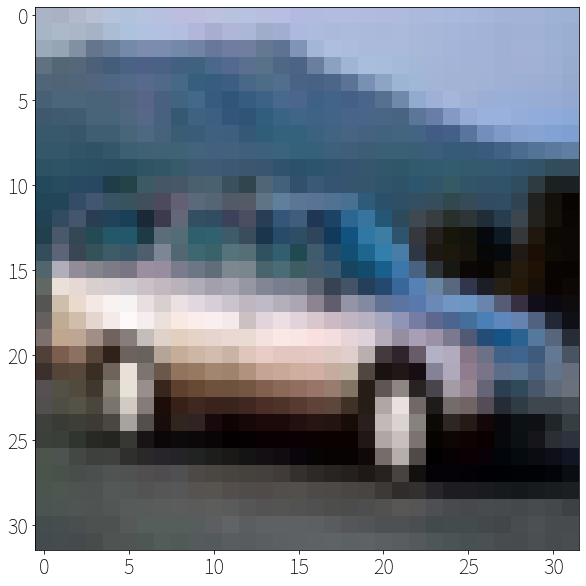

In [10]:
plt.imshow(X_train[4]/255)

CIFAR10 图片识别任务并不简单，这主要是由于 CIFAR10 的图片内容需要大量细节才能呈现，而保存的图片分辨率仅有32 × 32，使得部分主体信息较为模糊，甚至人眼都很难分辨。

In [11]:
# 1. 卷积子网络
conv_layers = [
    # 64个 3X3 的卷积核 输出与输入同大小
    layers.Conv2D(64, kernel_size=(3, 3), padding='SAME', activation='relu'),
    layers.Conv2D(64, kernel_size=(3, 3), padding='SAME', activation='relu'),
    # 池化层 高宽减半
    layers.MaxPool2D(pool_size=(2, 2), strides=2, padding='same'),
    # Conv-Conv-Pooling 单元2  输出通道提升至 128，高宽大小减半
    layers.Conv2D(128, kernel_size=(3, 3), padding='SAME', activation='relu'),
    layers.Conv2D(128, kernel_size=(3, 3), padding='SAME', activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2), strides=2, padding='same'),
    # Conv-Conv-Pooling 单元3  输出通道提升至 256，高宽大小减半
    layers.Conv2D(256, kernel_size=(3, 3), padding='SAME', activation='relu'),
    layers.Conv2D(256, kernel_size=(3, 3), padding='SAME', activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2), strides=2, padding='same'),
    # Conv-Conv-Pooling 单元4  输出通道提升至 512，高宽大小减半
    layers.Conv2D(512, kernel_size=(3, 3), padding='SAME', activation='relu'),
    layers.Conv2D(512, kernel_size=(3, 3), padding='SAME', activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2), strides=2, padding='same'),
    # Conv-Conv-Pooling 单元4  输出通道提升至 512，高宽大小减半
    layers.Conv2D(512, kernel_size=(3, 3), padding='SAME', activation='relu'),
    layers.Conv2D(512, kernel_size=(3, 3), padding='SAME', activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2), strides=2, padding='same'),
]

In [12]:
conv_net = Sequential(conv_layers)

In [13]:
fc_net = Sequential([
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation=None)
])

In [14]:
# conv_net.build(input_shape=(None, 32, 32, 3))
# fc_net.build(input_shape=(None, 512)) 

In [15]:
# conv_net.summary()

In [16]:
# fc_net.summary()

In [17]:
(3 * 3 * 3 + 1) * 64

1792

In [18]:
(3 * 3 * 64 + 1) * 64

36928

In [19]:
50000 / 128

390.625

In [20]:
def VGG16():
    loss = []
    acc = []
    metric_acc = metrics.Accuracy()
    optimizer = optimizers.Adam(0.0001)
    conv_net.build(input_shape=(None, 32, 32, 3))
    fc_net.build(input_shape=(None, 512)) 
    variables = conv_net.trainable_variables + fc_net.trainable_variables
    
    for epoch in range(50):
        for step, (x, y) in enumerate(train_db):
            with tf.GradientTape() as tape:
                out = conv_net(x)
                out = tf.reshape(out, (-1, 512))

                out = fc_net(out)
                # print(out.shape)
                y_onehot = tf.one_hot(y, depth=10)
                cost = losses.categorical_crossentropy(y_onehot, out, from_logits=True)
                cost =tf.reduce_mean(cost)
            grads = tape.gradient(cost, variables)
            optimizer.apply_gradients(zip(grads, variables))
            
            if step % 100 == 0:
                loss.append(float(cost))
                print(f"epoch: {epoch}, step: {step}, loss: {float(cost)}")
        
        # 每个epoch 检测一次test
        metric_acc.reset_states()
        for x, y in test_db:
            out = conv_net(x)
            out = tf.reshape(out, (-1, 512))

            out = fc_net(out)
            y_pred = tf.argmax(out, axis=-1)
            metric_acc.update_state(y, y_pred)
        print(f"epoch :{epoch},  accuracy: {float(metric_acc.result())}")
        acc.append(float(metric_acc.result()))
    return loss, acc

In [21]:
VGG16()

epoch: 0, step: 0, loss: 2.3025529384613037
epoch: 0, step: 100, loss: 1.9708839654922485
epoch: 0, step: 200, loss: 1.8092079162597656
epoch: 0, step: 300, loss: 1.5598812103271484
epoch :0,  accuracy: 0.44429999589920044
epoch: 1, step: 0, loss: 1.4980831146240234
epoch: 1, step: 100, loss: 1.634993314743042
epoch: 1, step: 200, loss: 1.353920578956604
epoch: 1, step: 300, loss: 1.4722709655761719
epoch :1,  accuracy: 0.5329999923706055
epoch: 2, step: 0, loss: 1.2172331809997559
epoch: 2, step: 100, loss: 1.0733684301376343
epoch: 2, step: 200, loss: 1.0692987442016602
epoch: 2, step: 300, loss: 1.049787998199463
epoch :2,  accuracy: 0.5810999870300293
epoch: 3, step: 0, loss: 1.2063064575195312
epoch: 3, step: 100, loss: 1.0844776630401611
epoch: 3, step: 200, loss: 1.0787405967712402
epoch: 3, step: 300, loss: 0.9257391691207886
epoch :3,  accuracy: 0.6452999711036682
epoch: 4, step: 0, loss: 0.9893485903739929
epoch: 4, step: 100, loss: 0.8584526181221008
epoch: 4, step: 200, los

KeyboardInterrupt: 